In [237]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime
import math
import gc

from sklearn.metrics import roc_auc_score

import lightgbm as lgbm

import pickle
def dump_pkl(data, filename):
  with open(filename, 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_pkl(filename):
  with open(filename, 'rb') as handle:
    data = pickle.load(handle)
  return data

In [172]:
df_ton = load_pkl('./data/raw/1hour/TON-USDT.pkl')
df_ton

,time,close,volume,ticker
0,2022-07-01 00:00:00,1.0775,18435.4706,TON-USDT
1,2022-07-01 01:00:00,1.0782,5986.2163,TON-USDT
2,2022-07-01 02:00:00,1.0931,15773.0364,TON-USDT
3,2022-07-01 03:00:00,1.1224,24153.4634,TON-USDT
4,2022-07-01 04:00:00,1.1353,48440.1406,TON-USDT
...,...,...,...,...
23434,2025-03-03 10:00:00,3.3670,158467.0570,TON-USDT
23435,2025-03-03 11:00:00,3.3300,162247.5814,TON-USDT
23436,2025-03-03 12:00:00,3.3660,187775.6478,TON-USDT
23437,2025-03-03 13:00:00,3.3760,128421.1926,TON-USDT


In [176]:
df_near = load_pkl('./data/raw/1hour/NEAR-USDT.pkl')
df_near

,time,close,volume,ticker
0,2022-07-01 00:00:00,3.222,58257.442553,NEAR-USDT
1,2022-07-01 01:00:00,3.239,91519.159300,NEAR-USDT
2,2022-07-01 02:00:00,3.335,213150.300759,NEAR-USDT
3,2022-07-01 03:00:00,3.390,372963.783107,NEAR-USDT
4,2022-07-01 04:00:00,3.388,102250.366799,NEAR-USDT
...,...,...,...,...
23434,2025-03-03 10:00:00,3.317,63085.304690,NEAR-USDT
23435,2025-03-03 11:00:00,3.253,85327.375445,NEAR-USDT
23436,2025-03-03 12:00:00,3.275,97010.321312,NEAR-USDT
23437,2025-03-03 13:00:00,3.303,36493.388157,NEAR-USDT


In [545]:
df = df_ton[['time']].copy()
df['ton_close'] = df_ton['close']
df['near_close'] = df_near['close']

df['ton/near'] = df['ton_close'] / df['near_close']
df['close'] = df['ton_close'] / df['near_close']

window = 24*1
df['ton/near_ma1'] = df['ton/near'].rolling(window=window, min_periods=window).mean().values
window = 24*3
df['ton/near_ma3'] = df['ton/near'].rolling(window=window, min_periods=window).mean().values
# window = 24*20
# df['ton/near_ma20'] = df['ton/near'].rolling(window=window, min_periods=window).mean().values


df['ton/near_ma1/3'] = df['ton/near_ma1']/ df['ton/near_ma3']
# df['ton/near_ma5/20'] = df['ton/near_ma5']/ df['ton/near_ma20']
# df['ton/near_ma10/20'] = df['ton/near_ma10']/ df['ton/near_ma20']

#df['x'] = df['ton/near'] / df['ton/near_ma']

df['ticker'] = 'ton/near'

df

,time,ton_close,near_close,ton/near,close,ton/near_ma1,ton/near_ma3,ton/near_ma1/3,ticker
0,2022-07-01 00:00:00,1.0775,3.222,0.334420,0.334420,NaN,NaN,NaN,ton/near
1,2022-07-01 01:00:00,1.0782,3.239,0.332881,0.332881,NaN,NaN,NaN,ton/near
2,2022-07-01 02:00:00,1.0931,3.335,0.327766,0.327766,NaN,NaN,NaN,ton/near
3,2022-07-01 03:00:00,1.1224,3.390,0.331091,0.331091,NaN,NaN,NaN,ton/near
4,2022-07-01 04:00:00,1.1353,3.388,0.335094,0.335094,NaN,NaN,NaN,ton/near
...,...,...,...,...,...,...,...,...,...
23434,2025-03-03 10:00:00,3.3670,3.317,1.015074,1.015074,1.009364,1.043416,0.967364,ton/near
23435,2025-03-03 11:00:00,3.3300,3.253,1.023670,1.023670,1.009634,1.041951,0.968984,ton/near
23436,2025-03-03 12:00:00,3.3660,3.275,1.027786,1.027786,1.009976,1.040564,0.970604,ton/near
23437,2025-03-03 13:00:00,3.3760,3.303,1.022101,1.022101,1.009979,1.038878,0.972183,ton/near


In [458]:
def get_target(df_all, ind, val_first, val_second, points_to_wait):
    #цель - достичь val_second, не достигнув val_first

    ind_end = min(ind+points_to_wait+1, df_all.shape[0])
    
    df = df_all.iloc[ind:ind_end].copy()
    
    mask_stock = np.array(df['ticker'] == df['ticker'].iloc[0])
    df = df.loc[mask_stock, :]

    start_price = df['close'].iloc[0]
    
    if val_first < val_second:                                 
        mask_val_first = np.array(df['close'] < val_first)
        mask_val_second = np.array(df['close'] > val_second)
    else: #short game
        mask_val_first = np.array(df['close'] > val_first)
        mask_val_second = np.array(df['close'] < val_second)

    
    if (mask_val_first.sum() == 0) & (mask_val_second.sum() == 0):

        ind_end = df.shape[0]-1
        delta_time = df['time'].iloc[ind_end] - df['time'].iloc[0]
        res_price = df['close'].iloc[ind_end]
        if val_first < val_second:
            income_rate = res_price/start_price
        else: #short game
            income_rate = (2*start_price-res_price)/start_price
        return 'DNF', delta_time, income_rate, res_price, ind_end+ind
        
    if (mask_val_first.sum() == 0) & (mask_val_second.sum() != 0):
        ind_val_second = np.argwhere(mask_val_second).ravel()[0]
        delta_time = df['time'].iloc[ind_val_second] - df['time'].iloc[0]
        res_price = df['close'].iloc[ind_val_second]
        if val_first < val_second:
            income_rate = res_price/start_price
        else: #short game
            income_rate = (2*start_price-res_price)/start_price
        return 'WIN', delta_time, income_rate, res_price, ind_val_second+ind
        
    if (mask_val_first.sum() != 0) & (mask_val_second.sum() == 0):
        ind_val_first = np.argwhere(mask_val_first).ravel()[0]
        delta_time = df['time'].iloc[ind_val_first] - df['time'].iloc[0]
        res_price = df['close'].iloc[ind_val_first]
        if val_first < val_second:
            income_rate = res_price/start_price
        else: #short game
            income_rate = (2*start_price-res_price)/start_price
        return 'LOSE', delta_time, income_rate, res_price, ind_val_first+ind

    if (mask_val_first.sum() != 0) & (mask_val_second.sum() != 0):
        ind_val_first = np.argwhere(mask_val_first).ravel()[0]
        ind_val_second = np.argwhere(mask_val_second).ravel()[0]
        if ind_val_first < ind_val_second:
            delta_time = df['time'].iloc[ind_val_first] - df['time'].iloc[0]
            res_price = df['close'].iloc[ind_val_first]
            if val_first < val_second:
                income_rate = res_price/start_price
            else: #short game
                income_rate = (2*start_price-res_price)/start_price
            return 'LOSE', delta_time, income_rate, res_price, ind_val_first+ind
        if ind_val_first > ind_val_second:
            delta_time = df['time'].iloc[ind_val_second] - df['time'].iloc[0]
            res_price = df['close'].iloc[ind_val_second]
            if val_first < val_second:
                income_rate = res_price/start_price
            else:  #short game
                income_rate = (2*start_price-res_price)/start_price
            return 'WIN', delta_time, income_rate, res_price, ind_val_second+ind


def get_df_target(df, indx, percent_first=None, percent_second=None, points_to_wait=None):
    times = []
    results = []
    delta_times = []
    income_rates = []
    closes = []
    tickers = []
    res_prices = []
    res_inds = []
    
    #for ind in indx:
    for ind in tqdm(indx):
        time = df['time'].iloc[ind]
        close = df['close'].iloc[ind]
        ticker = df['ticker'].iloc[ind]
        
        val_first = df['close'].iloc[ind] * percent_first
        val_second = df['close'].iloc[ind] * percent_second
        result, delta_time, income_rate, res_price, res_ind = get_target(df, ind, val_first, val_second, points_to_wait)
        
        times += [time]
        closes += [close]
        tickers += [ticker]
        results += [result]
        delta_times += [delta_time]
        income_rates += [income_rate]
        res_prices += [res_price]
        res_inds += [res_ind]
        

    df_result = pd.DataFrame({'ind' : indx,
                              'time' : times,
                              'close' : closes,
                              'result' : results,
                              'ticker' : tickers, 
                              'delta_time' : delta_times,
                              'income_rate' : income_rates,
                              'res_price' : res_prices,
                              'res_ind' : res_inds
                             })

    # #макс выигрыш и потери
    # if percent_first < percent_second:  
    #     df_result["income_rate"] = np.maximum(df_result["income_rate"], percent_first) #макс потери
    #     df_result["income_rate"] = np.minimum(df_result["income_rate"], percent_second) #макс выигрыш
    # else:
    #     df_result["income_rate"] = np.maximum(df_result["income_rate"], 2-percent_first) #макс потери
    #     df_result["income_rate"] = np.minimum(df_result["income_rate"], 2-percent_second) #макс выигрыш
    
    df_result['income_rate'] -= 0.002
    
    return df_result    

In [461]:
inds = np.arange(df.shape[0])
inds.shape

(23439,)

In [465]:
df_result = get_df_target(df[['time', 'close', 'ticker']], inds, percent_first=0.9, percent_second=1.10, points_to_wait=24*30)

100%|█████████████████████████████████████████████████████████████████| 23439/23439 [00:05<00:00, 4143.06it/s]


In [467]:
df_result['result'].value_counts(normalize=True)


result
WIN     0.538078
LOSE    0.451342
DNF     0.010581
Name: proportion, dtype: float64

In [469]:
df_result['income_rate'].quantile(q=[0, 0.01]+np.arange(0.1, 1, 0.1).tolist()+[0.99, 1])

0.00    0.803894
0.01    0.860063
0.10    0.885634
0.20    0.891736
0.30    0.894938
0.40    0.897131
0.50    1.098623
0.60    1.100494
0.70    1.102925
0.80    1.106630
0.90    1.113734
0.99    1.152285
1.00    1.417329
Name: income_rate, dtype: float64

In [472]:
df[['result', 'delta_time', 'income_rate', 'res_price', 'res_ind']] = df_result[['result', 'delta_time', 'income_rate', 'res_price', 'res_ind']]

df['target'] = (df['result'] == 'WIN').astype(int)
df

,time,ton_close,near_close,ton/near,close,ton/near_ma5,ton/near_ma10,ton/near_ma20,ton/near_ma5/10,ton/near_ma5/20,ton/near_ma10/20,ticker,result,delta_time,income_rate,res_price,res_ind,target
0,2022-07-01 00:00:00,1.0775,3.222,0.334420,0.334420,NaN,NaN,NaN,NaN,NaN,NaN,ton/near,LOSE,5 days 11:00:00,0.895511,0.300145,131,0
1,2022-07-01 01:00:00,1.0782,3.239,0.332881,0.332881,NaN,NaN,NaN,NaN,NaN,NaN,ton/near,LOSE,5 days 14:00:00,0.895893,0.298891,135,0
2,2022-07-01 02:00:00,1.0931,3.335,0.327766,0.327766,NaN,NaN,NaN,NaN,NaN,NaN,ton/near,LOSE,5 days 19:00:00,0.894786,0.293936,141,0
3,2022-07-01 03:00:00,1.1224,3.390,0.331091,0.331091,NaN,NaN,NaN,NaN,NaN,NaN,ton/near,LOSE,5 days 13:00:00,0.896343,0.297434,136,0
4,2022-07-01 04:00:00,1.1353,3.388,0.335094,0.335094,NaN,NaN,NaN,NaN,NaN,NaN,ton/near,LOSE,5 days 07:00:00,0.893703,0.300145,131,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23434,2025-03-03 10:00:00,3.3670,3.317,1.015074,1.015074,1.080564,1.092325,1.105434,0.989233,0.977502,0.988142,ton/near,DNF,0 days 04:00:00,0.995662,1.012700,23438,0
23435,2025-03-03 11:00:00,3.3300,3.253,1.023670,1.023670,1.079288,1.092363,1.105158,0.988030,0.976592,0.988423,ton/near,DNF,0 days 03:00:00,0.987284,1.012700,23438,0
23436,2025-03-03 12:00:00,3.3660,3.275,1.027786,1.027786,1.078092,1.092418,1.104896,0.986886,0.975740,0.988707,ton/near,DNF,0 days 02:00:00,0.983322,1.012700,23438,0
23437,2025-03-03 13:00:00,3.3760,3.303,1.022101,1.022101,1.076901,1.092497,1.104640,0.985725,0.974889,0.989007,ton/near,DNF,0 days 01:00:00,0.988802,1.012700,23438,0


In [474]:
mask_train = np.array((pd.Timestamp('2024-07-01') <= df['time']) & (df['time'] < pd.Timestamp('2024-11-01')))
mask_valid = np.array((pd.Timestamp('2024-11-01') <= df['time']) & (df['time'] < pd.Timestamp('2025-01-01')))
mask_test = np.array(pd.Timestamp('2025-01-01') <= df['time'])

In [476]:
mask_train.sum(), mask_valid.sum(), mask_test.sum()

(2952, 1464, 1479)

In [478]:
df.loc[mask_train, 'target'].mean(), df.loc[mask_valid, 'target'].mean(), df.loc[mask_test, 'target'].mean()

(0.5965447154471545, 0.42349726775956287, 0.4874915483434753)

In [480]:
df.loc[mask_train, 'income_rate'].mean(), df.loc[mask_valid, 'income_rate'].mean(), df.loc[mask_test, 'income_rate'].mean()

(1.021021375221356, 0.9808577092814268, 1.0005068524866305)

In [497]:
features = ['ton/near_ma5/10', 'ton/near_ma5/20', 'ton/near_ma10/20']
cat_features = []

target = 'target'

In [499]:


D_train = lgbm.Dataset(df.loc[mask_train, features], label=df.loc[mask_train, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_valid = lgbm.Dataset(df.loc[mask_valid, features], label=df.loc[mask_valid, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test = lgbm.Dataset(df.loc[mask_test, features], label=df.loc[mask_test, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)


D_train.income_rate = df.loc[mask_train, 'income_rate'].values
D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
D_test.income_rate = df.loc[mask_test, 'income_rate'].values

D_train.time = df.loc[mask_train, 'time'].values
D_valid.time = df.loc[mask_valid, 'time'].values
D_test.time = df.loc[mask_test, 'time'].values

In [505]:
def mean_income_rate(y_pred, D_sample):
    q = 0.99
    mask = y_pred >= np.quantile(y_pred, q)
    #mask = y_pred >= threshold
    df_sup = pd.DataFrame({'time' : D_sample.time,
                           'income_rate' : D_sample.income_rate,
                           'y_pred' : y_pred})
    # month
    # score = (df_sup[mask].groupby('time').income_rate.mean()-1).reset_index().groupby(pd.Grouper(key='time', frethreshold='D')).income_rate.mean().mean() * df_sup.loc[mask, 'time'].dt.date.nunique() 
    # score = score * (22 / df_sup['time'].dt.date.nunique()) #22 day in month

    # tick
    score = (df_sup[mask].groupby('time').income_rate.mean()-1).mean()
    
    # point
    # score = np.mean(D_sample.income_rate[mask]) - 1

    #point win_rate
    # score = np.mean(D_sample.label[mask])

    score = round(score, 5)
    return 'mean_income_rate', score, True#is_higher_better



params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    
    
    "num_boost_round" : 1000,

    
    "num_leaves": 2,
    #"learning_rate": 0.001,
     "feature_fraction": 1,
     "bagging_fraction": 1,
     "bagging_freq": 1,
     'lambda_l1' : 1,
     'lambda_l2' : 1,
    #"verbose": 0,

    #'max_bin' : 100000,
    
    
    #"metric": "auc",
     "metric" : 'mean_income_rate',
     "early_stopping" : 10,



    
}


    

model = lgbm.train(params, train_set=D_train, valid_sets=[D_valid], feval=mean_income_rate, )

[LightGBM] [Info] Number of positive: 1761, number of negative: 1191
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 2952, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.596545 -> initscore=0.391089
[LightGBM] [Info] Start training from score 0.391089
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's mean_income_rate: 0.02468


/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument



In [507]:
model.num_trees()

1

In [513]:
y_pred_train = model.predict(D_train.data)
y_pred_valid = model.predict(D_valid.data)
y_pred_test = model.predict(D_test.data)


df["y_pred"] = None
df.loc[mask_train, 'y_pred'] = y_pred_train
df.loc[mask_valid, 'y_pred'] = y_pred_valid
df.loc[mask_test, 'y_pred'] = y_pred_test

roc_auc_score(D_train.label, y_pred_train), roc_auc_score(D_valid.label, y_pred_valid), roc_auc_score(D_test.label, y_pred_test)


(0.6829135895708444, 0.7468009478672987, 0.506351117438035)

In [515]:
#свой threshold

q = 0.99

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest')
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())




Valid
result
WIN     0.619312
LOSE    0.380688
Name: proportion, dtype: float64
1.0246848268608146

Test
result
WIN     0.493878
LOSE    0.412245
DNF     0.093878
Name: proportion, dtype: float64
1.006235920559504


In [517]:
#общий threshold

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
print(f'threshokd = {threshold}')

mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print("\nTest")
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

threshokd = 0.6126149554830133

Valid
result
WIN     0.619312
LOSE    0.380688
Name: proportion, dtype: float64
1.0246848268608146

Test
result
WIN     0.493878
LOSE    0.412245
DNF     0.093878
Name: proportion, dtype: float64
1.006235920559504


In [602]:
df = df_ton[['time']].copy()
df['ton_close'] = df_ton['close']
df['near_close'] = df_near['close']

df['ton/near'] = df['ton_close'] / df['near_close']
df['close'] = df['ton_close'] / df['near_close']

window = 24*1
df['ton/near_ma2'] = df['ton/near'].rolling(window=window, min_periods=window).mean().values
window = 24*5
df['ton/near_ma5'] = df['ton/near'].rolling(window=window, min_periods=window).mean().values
# window = 24*20
# df['ton/near_ma20'] = df['ton/near'].rolling(window=window, min_periods=window).mean().values


#df['ton/near_ma2/4'] = df['ton/near_ma2']/ df['ton/near_ma4']
# df['ton/near_ma5/20'] = df['ton/near_ma5']/ df['ton/near_ma20']
# df['ton/near_ma10/20'] = df['ton/near_ma10']/ df['ton/near_ma20']

#df['x'] = df['ton/near'] / df['ton/near_ma']

df['ticker'] = 'ton/near'

df

,time,ton_close,near_close,ton/near,close,ton/near_ma2,ton/near_ma5,ticker
0,2022-07-01 00:00:00,1.0775,3.222,0.334420,0.334420,NaN,NaN,ton/near
1,2022-07-01 01:00:00,1.0782,3.239,0.332881,0.332881,NaN,NaN,ton/near
2,2022-07-01 02:00:00,1.0931,3.335,0.327766,0.327766,NaN,NaN,ton/near
3,2022-07-01 03:00:00,1.1224,3.390,0.331091,0.331091,NaN,NaN,ton/near
4,2022-07-01 04:00:00,1.1353,3.388,0.335094,0.335094,NaN,NaN,ton/near
...,...,...,...,...,...,...,...,...
23434,2025-03-03 10:00:00,3.3670,3.317,1.015074,1.015074,1.009364,1.080564,ton/near
23435,2025-03-03 11:00:00,3.3300,3.253,1.023670,1.023670,1.009634,1.079288,ton/near
23436,2025-03-03 12:00:00,3.3660,3.275,1.027786,1.027786,1.009976,1.078092,ton/near
23437,2025-03-03 13:00:00,3.3760,3.303,1.022101,1.022101,1.009979,1.076901,ton/near


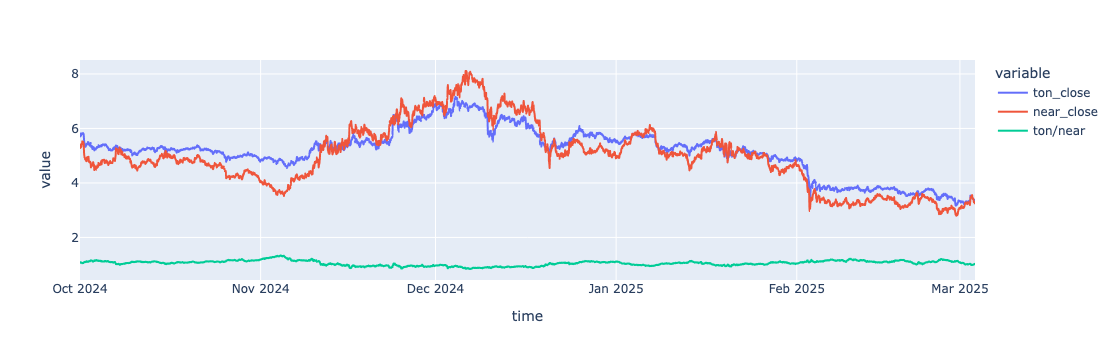

In [613]:
import plotly.express as px
mask = df['time'] >= pd.Timestamp('2024-10-01')
px.line(df.loc[mask, ['time','ton_close', 'near_close', 'ton/near']].set_index('time'))

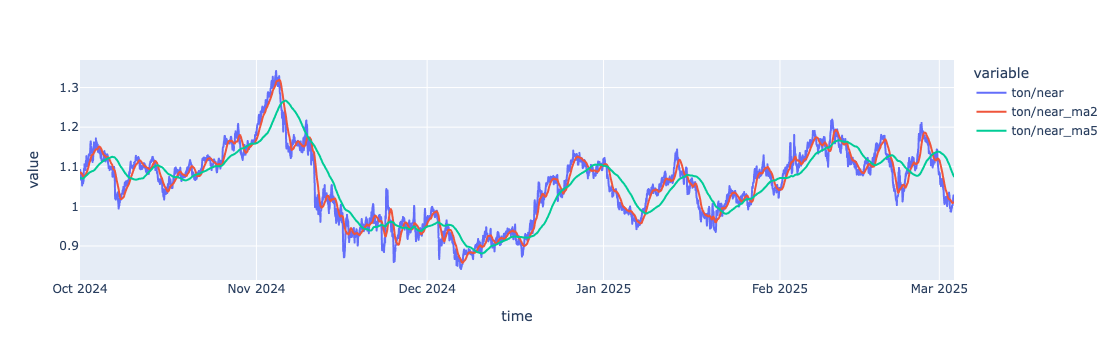

In [615]:
px.line(df.loc[mask, ['time','ton/near', 'ton/near_ma2', 'ton/near_ma5']].set_index('time'))

In [ ]:
Ждем перегиб, ставка на расхождение
17% процентов фиксим

In [161]:
df.loc[mask, ['ton/near']].mean()

ton/near    1.055458
dtype: float64

In [151]:
df.loc[mask, ['ton/near']].quantile(q=[0, 0.01]+np.arange(0.1, 1, 0.1).tolist()+[0.99, 1])

,ton/near
0.00,0.986775
0.01,0.998116
0.10,1.044190
0.20,1.082565
0.30,1.096489
0.40,1.107990
0.50,1.116790
0.60,1.128462
0.70,1.148738
0.80,1.161032


In [154]:
df.loc[mask&(df['ton/near'] <= 1), 'time']

23421   2025-03-02 21:00:00
23422   2025-03-02 22:00:00
23423   2025-03-02 23:00:00
23424   2025-03-03 00:00:00
23425   2025-03-03 01:00:00
23426   2025-03-03 02:00:00
23427   2025-03-03 03:00:00
23429   2025-03-03 05:00:00
Name: time, dtype: datetime64[ns]

In [156]:
mask = df['time'] >= pd.Timestamp('2025-02-01')
df.loc[mask, 'ton/near'].min()

0.9867754642656162